In [2]:
import numpy as np
import matplotlib.pyplot as plt


def apply_pbc(pos, lbox):
    """
    wrap positions inside simulation box

    Args:
        pos (np.array): positions, shape (natom, 3)
        lbox (float): box side length
    Returns:
        np.array: pos in box
    """

    return pos - lbox * np.round(pos / lbox)


def KE(vel, mass):
    """
    Calculate total kinetic energy.

    Args:
        vel (np.array): particle velocities, shape (nparticle, 3)
        mass (float): particle mass
    Return:
        float: total kinetic energy
    """

    return np.sum(np.linalg.norm(vel) ** 2 / 2 * mass)


def PE(distance_table):
    """
    Calculate total potential energy.

    Args:
        distance_table (np.array): distance table, shape (nparticles, nparticles)
    Return:
        float: total potential energy
    """

    n = distance_table.shape[0]
    # Create an upper triangular mask
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    r = distance_table[mask]  # Extract the upper triangular elements of rij
    sixth = 1 / r**6
    pe = np.sum(a=4 * sixth * (sixth - 1))

    return pe


def distance(pos, lbox):
    """
    Compute distance table and rij vectors

    Args:
        pos (np.array) : particle positions, shape (nparticles, 3)
        lbox (float): side length of cubic box
    Returns:
        np.array: distance table, shape (nparticles, nparticles)
        np.array: rij vectors, shape (nparticles, nparticles, 3)
    """

    rij = pos[:, np.newaxis, :] - pos
    rij = apply_pbc(rij, lbox)
    distance_table = np.linalg.norm(rij, axis=2)

    return distance_table, rij


def F_all(rij, distance_table):
    """
    Compute force on all particles

    Args:
        rij (np.array) : distance vectors, shape (nparticles, nparticles, 3)
        distance_table (np.array): distance table, shape (nparticles, nparticles)
    Returns:
        np.array: force on all particles, shape (nparticles, 3)
    """

    n = rij.shape[0]
    mask = ~np.eye(n, dtype=bool)
    rij = rij[mask].reshape(n, -1, 3)  # Remove self-interaction
    distance_table = distance_table[mask].reshape(n, -1)  # Remove self-interaction
    sixth = (1 / distance_table) ** 6
    factor = (1 / distance_table**2) * sixth * (2 * sixth - 1)
    factor = factor[:, :, np.newaxis]
    force = np.sum(factor * rij, axis=1)

    return 24 * force


def actime(E):
    mu = np.mean(E)
    std = np.std(E, ddof=1)
    N = E.shape[0]
    ts = np.arange(0, N, 1)

    a_diffs = np.zeros((N, N))

    for t in ts:
        a_diffs[t][: N - t] = (E[: N - t] - mu) * (E[t:] - mu)

    autocorrelation = np.sum(a_diffs, axis=1) / std**2 / (N - ts)
    tcutoff = (
        np.where(autocorrelation <= 0)[0][0] if (autocorrelation <= 0).any() else 0
    )
    kappa = 1 + 2 * np.sum(autocorrelation[1:tcutoff])

    return kappa, tcutoff

In [3]:
def InitPositionCubic(Ncube, L):
    """
    Places Ncube^3 atoms in a cubic box

    Args:
        Ncube (int): cube root number of atoms
        L (float): box side length
    Returns:
        np.array: positions, shape (Ncube**3, 3)
    """

    rs = L / Ncube
    roffset = L / 2 - rs / 2
    x = np.linspace(-roffset, roffset, Ncube)
    # Create a grid of positions using numpy broadcasting
    x, y, z = np.meshgrid(x, x, x, indexing="ij")
    # Stack the positions into a single array
    position = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

    return position


def InitVelocity(N, T0, mass=1.0, seed=1):
    """
    Initialize velocities from a Maxwell-Boltzmann distribution

    Args:
        N (int): number of particles
        T0 (float): temperature
        mass (float): particle mass
        seed (int): random seed
    Returns:
        np.array: velocities, shape (N, 3)
    """

    dim = 3
    np.random.seed(seed)
    # generate N x dim array of random numbers, and shift to be [-0.5, 0.5)
    velocity = np.random.random((N, dim)) - 0.5
    # get the average along the first axis
    meanV = np.sum(velocity, axis=0) / N
    # subtract off meanV, so there is no net momentum
    velocity -= meanV
    # calculate the total of V^2
    ke = np.sum(velocity * velocity)
    # calculate a scaling factor
    vscale = np.sqrt(dim * N * T0 / (mass * ke))
    # rescale
    velocity *= vscale

    return velocity


def VerletNextR(r_t, v_t, a_t, h):
    """
    Return new positions after one Verlet step

    Args:
        r_t (np.array): positions at time t, shape (nparticles, ndim)
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        h (float): timestep
    Returns:
        np.array: positions at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    r_t_plus_h = r_t + v_t * h + 0.5 * a_t * h * h

    return r_t_plus_h


def VerletNextV(v_t, a_t, a_t_plus_h, h):
    """
    Return new velocities after one Verlet step

    Args:
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        a_t_plus_h (np.array): accelerations at time t+h, shape (nparticles, ndim)
        h (float): timestep

    Returns:
        np.array: velocities at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    v_t_plus_h = v_t + 0.5 * (a_t + a_t_plus_h) * h

    return v_t_plus_h

In [4]:
def pair_correlation(dists, natom, nbins, dr, lbox, timestep):
    """
    Calculate the pair correlation function g(r) at time t

    Args:
        dists (np.array): 1d array of pair distances
        natom (int): number of atoms
        nbins (int): number of bins to histogram
        dr (float): size of bins
        lbox (float): side length of cubic box
        timestep (int): time index at which the pair correlation is calculated
    Returns:
        array of shape (nbins,): the pair correlation g(r)
    """

    def hist(a):
        return np.histogram(a, bins=nbins)[0]

    histogram = np.mean(np.apply_along_axis(hist, axis=1, arr=dists[timestep]), axis=0)

    r = (np.arange(0, (nbins + 1) * dr, dr) + dr / 2)[:-1]  # centers of the bins
    V = lbox**3
    shell_volume = 4.0 * np.pi / 3.0 * ((r + dr / 2) ** 3 - (r - dr / 2) ** 3)
    histogram[0] = 0
    g = 2 * histogram * V / (natom * (natom - 1)) / shell_volume

    return g


def legal_kvecs(maxn, lbox):
    """
    Calculate k vectors commensurate with a cubic box.

    Consider only k vectors in the all-positive octant of reciprocal space.

    Args:
        maxn : maximum value for nx, ny, nz; maxn+1 is number of k-points along each axis
        lbox : side length of cubic cell

    Returns:
        array of shape (nk, ndim): collection of k vectors
    """
    n = np.arange(maxn + 1)
    n = np.vstack(np.meshgrid(n, n, n)).reshape(3, -1).T
    kvecs = 2 * np.pi / lbox * n
    tmp = np.array(kvecs[:, 0])
    kvecs[:, 0] = kvecs[:, 1]
    kvecs[:, 1] = tmp
    return kvecs


def calc_rhok(kvecs, pos):
    """
    Calculate the fourier transform of particle density.

    Args:
        kvecs (np.array): array of k-vectors, shape (nk, ndim)
        pos (np.array): particle positions, shape (natom, ndim)
    Returns:
        array of shape (nk,): fourier transformed density rho_k
    """
    return np.sum(np.exp(-1j * np.dot(kvecs, pos.T)), axis=-1)


def calc_sk(kvecs, pos):
    """
    Calculate the structure factor S(k).

    Args:
        kvecs (np.array): array of k-vectors, shape (nk, ndim)
        pos (np.array): particle positions, shape (natom, ndim)
    Returns:
        array of shape (nk,): structure factor s(k)
    """
    return calc_rhok(kvecs, pos) * calc_rhok(-kvecs, pos) / pos.shape[0]


def calc_vacf0(all_vel, t):
    """
    Calculate the vacf using t_0=0.

    Args:
        all_vel (np.array): shape (nstep, natom, ndim), all particle velocities
        from an MD trajectory. For example all_vel[t, i] is the velocity
        vector of particle i at time t.
        t (int): time index at which the velocity auto-correlation is calculated.
    Returns:
        float: the velocity autocorrelation between time 0 and time t
    """
    vacf = 0
    for i in range(all_vel.shape[1]):
        vacf += np.dot(all_vel[0, i], all_vel[t, i])
    return vacf / all_vel.shape[1]


def diffusion_constant(vacf):
    """
    Calculate the diffusion constant from the
    velocity-velocity auto-correlation function (vacf).

    Args:
        vacf (np.array): shape (nt,), vacf sampled at
        nt time steps from t=0 to nt*dt. dt is set to 0.032.
    Returns:
        float: the diffusion constant calculated from the vacf.
    """
    dt = 0.032
    return np.trapz(vacf, dx=dt) / 3


def total_momentum(vel, mass):
    """
    Calculate total kinetic momentum.

    Args:
        vel (np.array): particle velocities, shape (nparticle, 3)
        mass (float): particle mass
    Returns:
        float: total momentum
    """

    return np.sum(vel * mass, axis=0)

In [5]:
def simulate(Ncube, T0, L, M, steps, h, thermostat=False, p=0.01, T_bath=None):
    """
    Initialize and run a simulation in a Ncube**3 box, for steps

    Args:
        Ncube (int): cube root number of atoms
        T0 (float): temperature
        L (float): box side length
        M (float): particle mass
        steps (int): number of steps to run
        h (float): timestep
    Returns:
        np.array: total energy, shape (steps,)
    """

    np.random.seed(1)

    # Initialize inputs
    N = Ncube**3
    R = InitPositionCubic(Ncube, L)
    V = InitVelocity(N, T0, M)
    A = np.zeros((N, 3))

    # Initialize outputs
    E = np.zeros(steps)
    P = np.zeros((steps, 3))
    T = np.zeros(steps)
    Vs = np.zeros((steps, N, 3))
    Rs = np.zeros((steps, N, 3))
    distances = np.zeros((steps, N, N))

    # Calculate initial Forces and accelerations (N x 3 array)
    distance_table, rij = distance(R, L)
    F = F_all(rij, distance_table)
    A = F / M

    for t in range(0, steps):
        # Calculate energy, temperature, and momentum
        E[t] = KE(V, M)
        T[t] = 2 * E[t] / (3 * N)
        E[t] += PE(distance_table)
        P[t] = total_momentum(V, M)

        # Save velocities, positions, and distances
        Vs[t] = V
        Rs[t] = R
        distances[t] = distance_table

        # Calculate next positions and apply PBC
        nR = VerletNextR(R, V, A, h)
        nR = apply_pbc(nR, L)
        distance_table, rij = distance(nR, L)

        # Calculate next forces, accelerations, and velocities
        nF = F_all(rij, distance_table)
        nA = nF / M
        nV = VerletNextV(V, A, nA, h)

        if thermostat:
            collission_mask = np.random.rand(N) <= p
            if T_bath is None:
                nV[collission_mask] = np.random.normal(
                    0, np.sqrt(T0 / M), size=(np.sum(collission_mask), 3)
                )
            else:
                nV[collission_mask] = np.random.normal(
                    0, np.sqrt(T_bath / M), size=(np.sum(collission_mask), 3)
                )

        # update positions, velocities, accelerations and forces
        R, V, A, F = nR, nV, nA, nF

    return E, P, T, Vs, Rs, distances


In [14]:
T0 = 0.728  # temperature
L = 4.2323167  # box length
N = 64  # number of particles
M = 48.0  # mass of each particle
h = 0.032  # time step size
steps = 1000  # number of time steps

E, P, T, Vs, Rs, distances = simulate(4, T0, L, M, steps, h)


### 1.

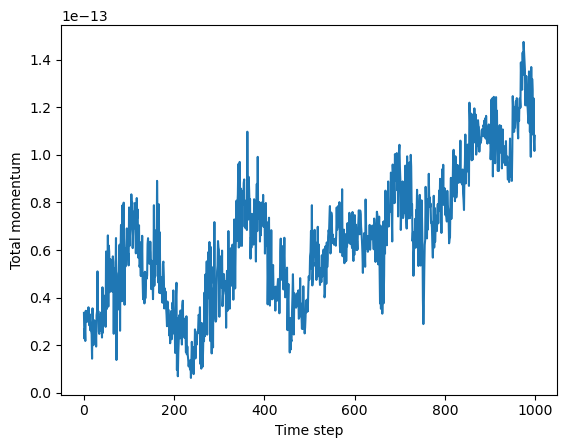

In [15]:
plt.plot(np.linalg.norm(P, axis=1))
plt.xlabel("Time step")
plt.ylabel("Total momentum")
plt.show()


Momentum is convserved, with fluctuations on the order of $10^{-13}$. This is expected, as there are no external forces acting on the system

### 2.

In [16]:
dr = 0.1
nbins = int(L / dr)

kappa, tcutoff = actime(E)

gs = np.zeros((steps, nbins))
for timestep in range(0, steps):
    if timestep <= tcutoff:
        continue

    gs[timestep] = pair_correlation(distances, N, nbins, dr, L, timestep)

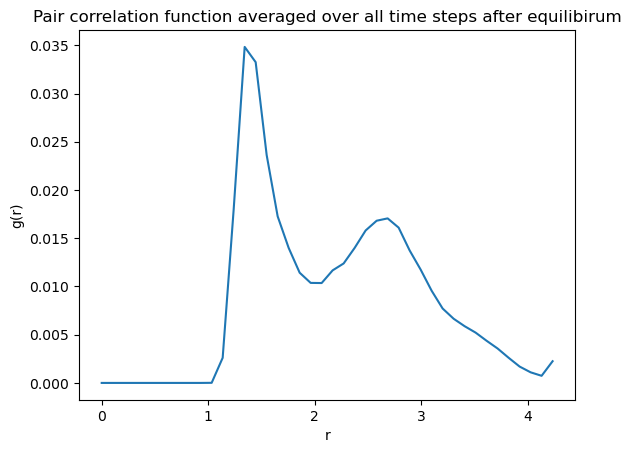

In [17]:
plt.plot(np.linspace(0, L, nbins), np.mean(gs[tcutoff:], axis=0))
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Pair correlation function averaged over all time steps after equilibirum")
plt.show()

### 3.

/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_22980/3623781350.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  unique_sk[iukmag] = np.mean(sk_arr[idx2avg])


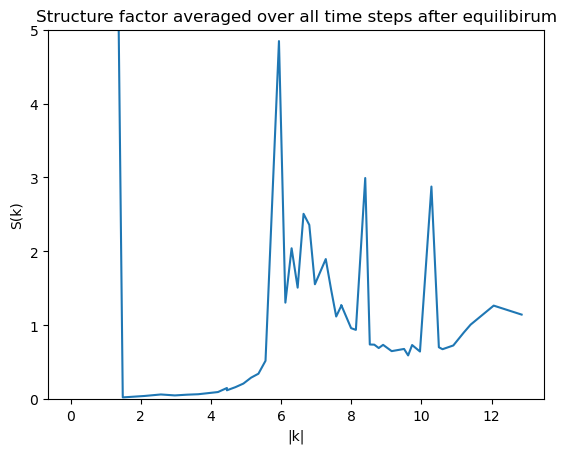

In [18]:
maxn = 5
unique_sks = np.zeros((steps, 47))

for timestep in range(0, steps):
    if timestep <= tcutoff:
        continue

    kvecs = legal_kvecs(5, L)
    kmags = np.linalg.norm(kvecs, axis=1)
    sk_arr = calc_sk(kvecs, Rs[timestep])
    unique_kmags = np.unique(kmags)
    unique_sk = np.zeros(unique_kmags.shape[0])
    for iukmag in range(unique_kmags.shape[0]):
        kmag = unique_kmags[iukmag]
        idx2avg = np.where(kmags == kmag)
        unique_sk[iukmag] = np.mean(sk_arr[idx2avg])

    unique_sks[timestep] = unique_sk

plt.plot(unique_kmags, np.mean(unique_sks[tcutoff:], axis=0))
plt.ylim(0, 5)
plt.xlabel("|k|")
plt.ylabel("S(k)")
plt.title("Structure factor averaged over all time steps after equilibirum")
plt.show()

For solids, g(r) and S(k) will have strong peaks, as the locations of atoms are fixed. For liquids, g(r) and S(k) will have weaker peaks, as the locations of atoms are not fixed.

### 4.

In [19]:
vacf = np.zeros(steps)

for timestep in range(0, steps):
    if timestep <= tcutoff:
        continue

    vacf[timestep] = calc_vacf0(Vs, timestep)

D = diffusion_constant(vacf[tcutoff:])

print("Diiffusion constant:", D)

Diiffusion constant: 0.010679348095525463


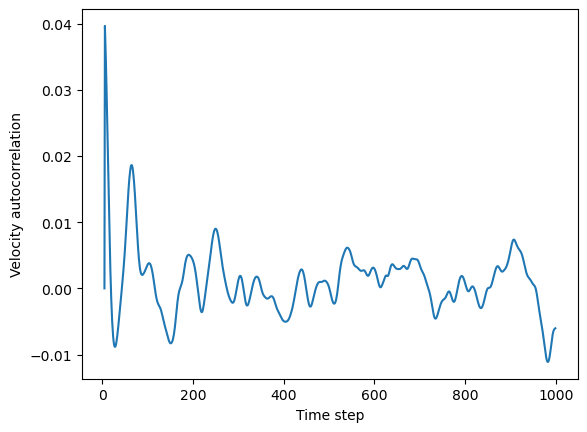

In [20]:
plt.plot(np.arange(tcutoff, steps, 1), vacf[tcutoff:])
plt.xlabel("Time step")
plt.ylabel("Velocity autocorrelation")
plt.show()

### 5.

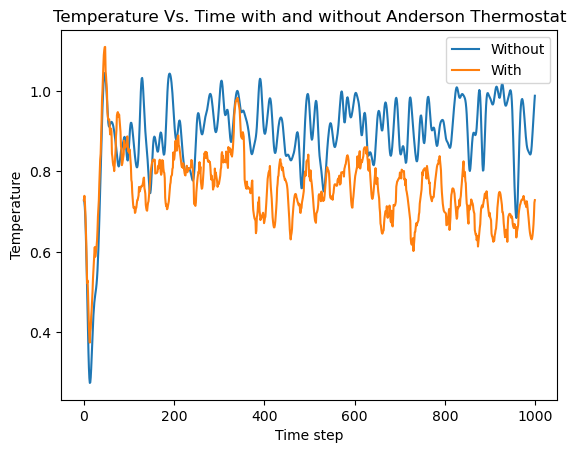

In [21]:
E, P, T, Vs, Rs, distances = simulate(4, T0, L, M, steps, h, thermostat=False)

plt.plot(T, label="Without")

E, P, T, Vs, Rs, distances = simulate(4, T0, L, M, steps, h, thermostat=True)

plt.plot(T, label="With")

plt.xlabel("Time step")
plt.ylabel("Temperature")
plt.legend()
plt.title("Temperature Vs. Time with and without Anderson Thermostat")
plt.show()


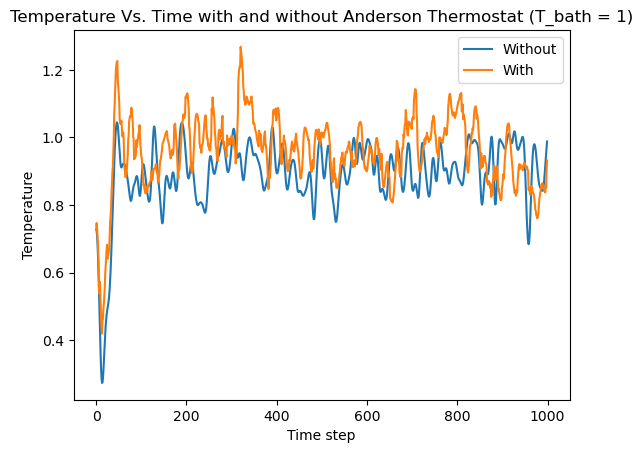

In [124]:
E, P, T, Vs, Rs, distances = simulate(4, T0, L, M, steps, h, thermostat=False)

plt.plot(T, label="Without")

E, P, T, Vs, Rs, distances = simulate(
    4, T0, L, M, steps, h, thermostat=True, T_bath=1.0
)

plt.plot(T, label="With")

plt.xlabel("Time step")
plt.ylabel("Temperature")
plt.legend()
plt.title("Temperature Vs. Time with and without Anderson Thermostat (T_bath = 1)")
plt.show()


### 6.

Diiffusion constant: -0.0008187812594540709


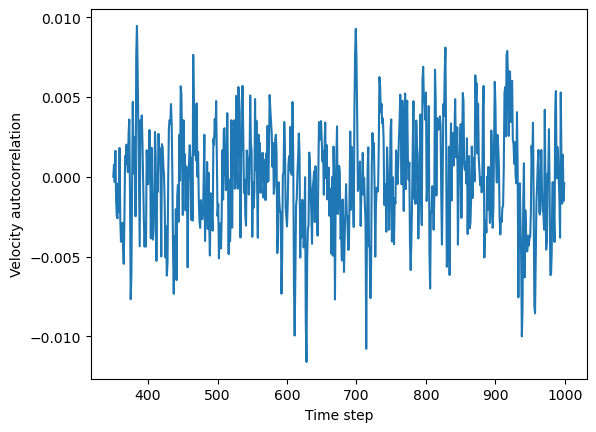

In [125]:
E, P, T, Vs, Rs, distances = simulate(4, T0, L, M, steps, h, thermostat=True, p=0.5)

kappa, tcutoff = actime(E)

vacf = np.zeros(steps)

for timestep in range(0, steps):
    if timestep <= tcutoff:
        continue

    vacf[timestep] = calc_vacf0(Vs, timestep)

D = diffusion_constant(vacf[tcutoff:])

print("Diiffusion constant:", D)

plt.plot(np.arange(tcutoff, steps, 1), vacf[tcutoff:])
plt.xlabel("Time step")
plt.ylabel("Velocity autocorrelation")
plt.show()

The velocity autocorrelation function becomes much more uncorrelated with the Anderson thermostat at high collission probability. As a result, the the diffusion constant should be lower. This is in fact what we see, with the diffusion consant in the microcanonical ensemble being $\approx 0.01$ and the diffusion constant in the canonical ensemble being $\approx -0.0008$. The negative indicates that the thermostat is causing the system to condense, very minimally due to the low order of magnitude.

### 7.

In [131]:
N = 64  # number of particles
M = 48.0  # mass of each particle
h = 0.032  # time step size
L = np.cbrt(N)  # box length
steps = 1000  # number of time steps

diffusion_constants = []
vacfs = []
gss = []
sks = []
Ts = [0.0, 1.0, 2.0, 3.0, 4.0]

for T0 in Ts:
    E, P, T, Vs, Rs, distances = simulate(
        4, T0, L, M, steps, h, thermostat=True, p=0.01
    )

    kappa, tcutoff = actime(E)

    vacf = np.zeros(steps)

    for timestep in range(0, steps):
        if timestep <= tcutoff:
            continue

        vacf[timestep] = calc_vacf0(Vs, timestep)

    D = diffusion_constant(vacf[tcutoff:])
    diffusion_constants.append(D)
    vacfs.append(vacf[tcutoff:])

    # print("Diiffusion constant:", D)

    # plt.plot(np.arange(tcutoff, steps, 1), vacf[tcutoff:], label = "T0 = " + str(T0))
    # plt.xlabel("Time step")
    # plt.ylabel("Velocity autocorrelation")
    # plt.legend()
    # plt.title("Velocity Autocorrelation Vs. Time for different T0")
    # plt.show()

    dr = 0.05
    nbins = int(L / dr)

    gs = np.zeros((steps, nbins))
    for timestep in range(0, steps):
        if timestep <= tcutoff:
            continue

        gs[timestep] = pair_correlation(distances, N, nbins, dr, L, timestep)

    gss.append(gs[tcutoff:])

    # plt.plot(np.linspace(0, L, nbins), np.mean(gs[tcutoff:], axis=0))
    # plt.xlabel("r")
    # plt.ylabel("g(r)")
    # plt.title("Pair correlation function averaged over all time steps after equilibirum")
    # plt.show()

    maxn = 5
    unique_sks = np.zeros((steps, 47))

    for timestep in range(0, steps):
        if timestep <= tcutoff:
            continue

        kvecs = legal_kvecs(5, L)
        kmags = np.linalg.norm(kvecs, axis=1)
        sk_arr = calc_sk(kvecs, Rs[timestep])
        unique_kmags = np.unique(kmags)
        unique_sk = np.zeros(unique_kmags.shape[0])
        for iukmag in range(unique_kmags.shape[0]):
            kmag = unique_kmags[iukmag]
            idx2avg = np.where(kmags == kmag)
            unique_sk[iukmag] = np.mean(sk_arr[idx2avg])

        unique_sks[timestep] = unique_sk

    sks.append(unique_sks[tcutoff:])

    # plt.plot(unique_kmags, np.mean(unique_sks[tcutoff:], axis=0))
    # plt.ylim(0, 5)
    # plt.xlabel("|k|")
    # plt.ylabel("S(k)")
    # plt.title("Structure factor averaged over all time steps after equilibirum")
    # plt.show()


/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_88165/3264186983.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  unique_sk[iukmag] = np.mean(sk_arr[idx2avg])


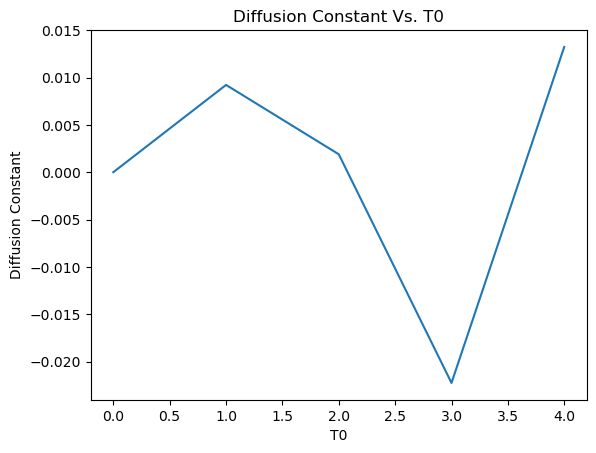

In [141]:
plt.plot(Ts, diffusion_constants)
plt.xlabel("T0")
plt.ylabel("Diffusion Constant")
plt.title("Diffusion Constant Vs. T0")
plt.show()

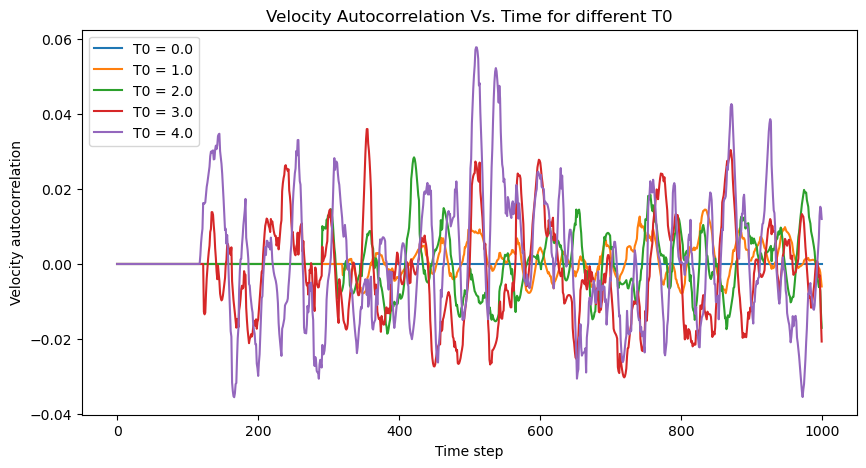

In [138]:
i = 0
for vacf in vacfs:
    plt.plot(vacf, label="T0 = " + str(Ts[i]))
    i += 1

plt.xlabel("Time step")
plt.ylabel("Velocity autocorrelation")
plt.legend()
plt.title("Velocity Autocorrelation Vs. Time for different T0")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


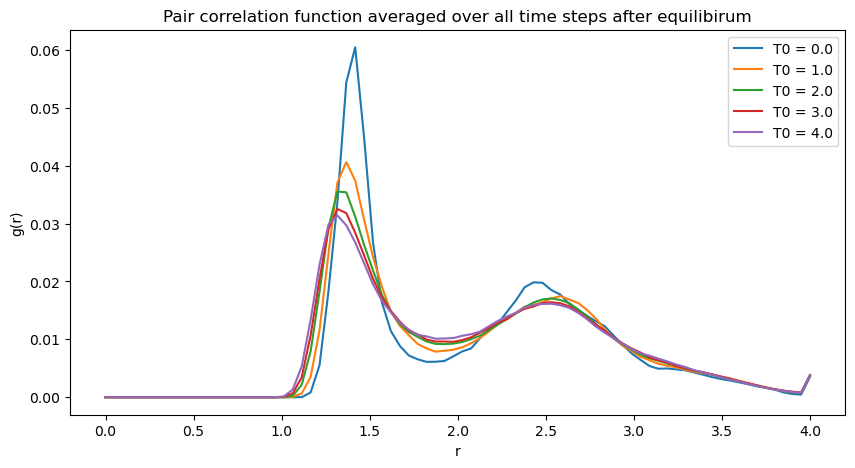

In [139]:
i = 0
for gs in gss:
    plt.plot(np.linspace(0, L, nbins), np.mean(
        gs, axis=0), label="T0 = " + str(Ts[i]))
    i += 1

plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Pair correlation function averaged over all time steps after equilibirum")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


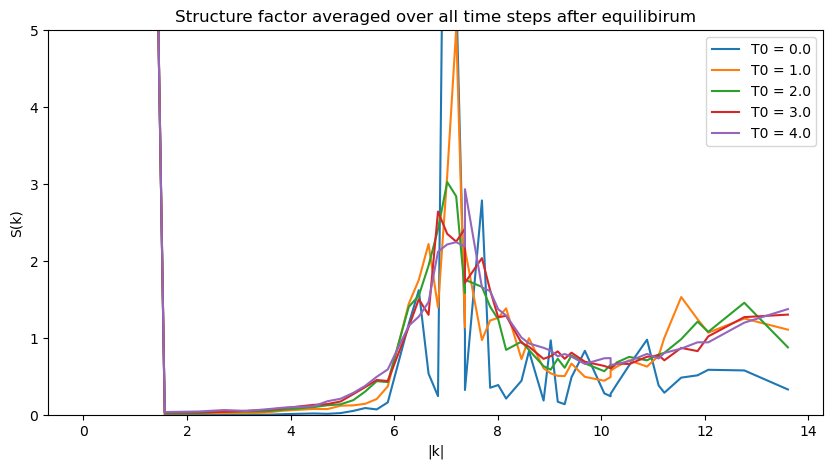

In [140]:
i = 0
for sk in sks:
    plt.plot(unique_kmags, np.mean(sk, axis=0), label="T0 = " + str(Ts[i]))
    i += 1

plt.ylim(0, 5)
plt.xlabel("|k|")
plt.ylabel("S(k)")
plt.title("Structure factor averaged over all time steps after equilibirum")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


In [142]:
N = 64  # number of particles
M = 48.0  # mass of each particle
h = 0.032  # time step size
L = np.cbrt(N)  # box length
steps = 1000  # number of time steps

diffusion_constants = []
vacfs = []
gss = []
sks = []
Ts = [0.05, 0.1, 0.15, 0.2]

for T0 in Ts:
    E, P, T, Vs, Rs, distances = simulate(
        4, T0, L, M, steps, h, thermostat=True, p=0.01
    )

    kappa, tcutoff = actime(E)

    vacf = np.zeros(steps)

    for timestep in range(0, steps):
        if timestep <= tcutoff:
            continue

        vacf[timestep] = calc_vacf0(Vs, timestep)

    D = diffusion_constant(vacf[tcutoff:])
    diffusion_constants.append(D)
    vacfs.append(vacf[tcutoff:])

    # print("Diiffusion constant:", D)

    # plt.plot(np.arange(tcutoff, steps, 1), vacf[tcutoff:], label = "T0 = " + str(T0))
    # plt.xlabel("Time step")
    # plt.ylabel("Velocity autocorrelation")
    # plt.legend()
    # plt.title("Velocity Autocorrelation Vs. Time for different T0")
    # plt.show()

    dr = 0.05
    nbins = int(L / dr)

    gs = np.zeros((steps, nbins))
    for timestep in range(0, steps):
        if timestep <= tcutoff:
            continue

        gs[timestep] = pair_correlation(distances, N, nbins, dr, L, timestep)

    gss.append(gs[tcutoff:])

    # plt.plot(np.linspace(0, L, nbins), np.mean(gs[tcutoff:], axis=0))
    # plt.xlabel("r")
    # plt.ylabel("g(r)")
    # plt.title("Pair correlation function averaged over all time steps after equilibirum")
    # plt.show()

    maxn = 5
    unique_sks = np.zeros((steps, 47))

    for timestep in range(0, steps):
        if timestep <= tcutoff:
            continue

        kvecs = legal_kvecs(5, L)
        kmags = np.linalg.norm(kvecs, axis=1)
        sk_arr = calc_sk(kvecs, Rs[timestep])
        unique_kmags = np.unique(kmags)
        unique_sk = np.zeros(unique_kmags.shape[0])
        for iukmag in range(unique_kmags.shape[0]):
            kmag = unique_kmags[iukmag]
            idx2avg = np.where(kmags == kmag)
            unique_sk[iukmag] = np.mean(sk_arr[idx2avg])

        unique_sks[timestep] = unique_sk

    sks.append(unique_sks[tcutoff:])

    # plt.plot(unique_kmags, np.mean(unique_sks[tcutoff:], axis=0))
    # plt.ylim(0, 5)
    # plt.xlabel("|k|")
    # plt.ylabel("S(k)")
    # plt.title("Structure factor averaged over all time steps after equilibirum")
    # plt.show()


/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_88165/1102721608.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  unique_sk[iukmag] = np.mean(sk_arr[idx2avg])


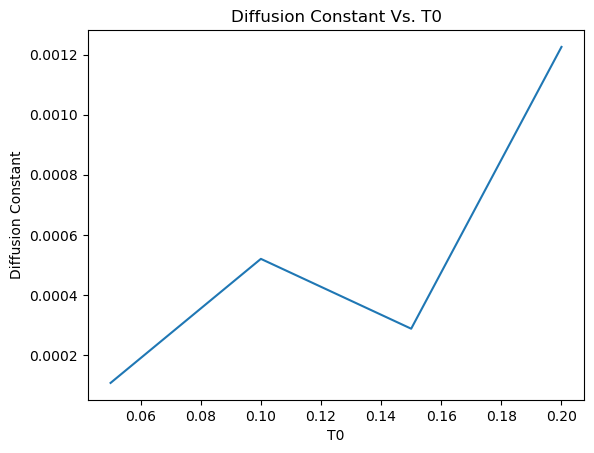

In [144]:
plt.plot(Ts, diffusion_constants)
plt.xlabel("T0")
plt.ylabel("Diffusion Constant")
plt.title("Diffusion Constant Vs. T0")
plt.show()

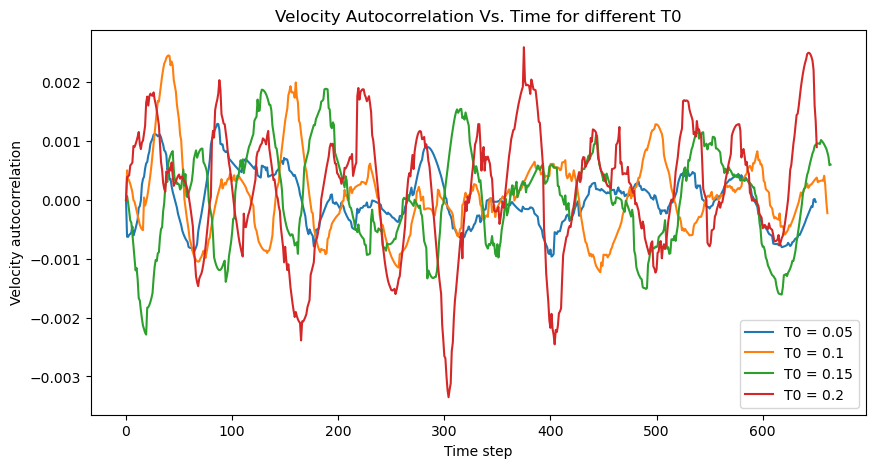

In [145]:
i = 0
for vacf in vacfs:
    plt.plot(vacf, label="T0 = " + str(Ts[i]))
    i += 1

plt.xlabel("Time step")
plt.ylabel("Velocity autocorrelation")
plt.legend()
plt.title("Velocity Autocorrelation Vs. Time for different T0")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


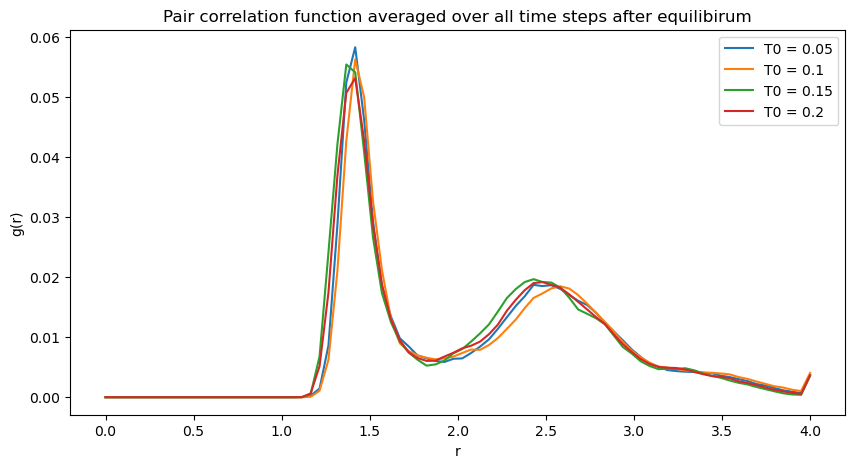

In [146]:
i = 0
for gs in gss:
    plt.plot(np.linspace(0, L, nbins), np.mean(
        gs, axis=0), label="T0 = " + str(Ts[i]))
    i += 1

plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Pair correlation function averaged over all time steps after equilibirum")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


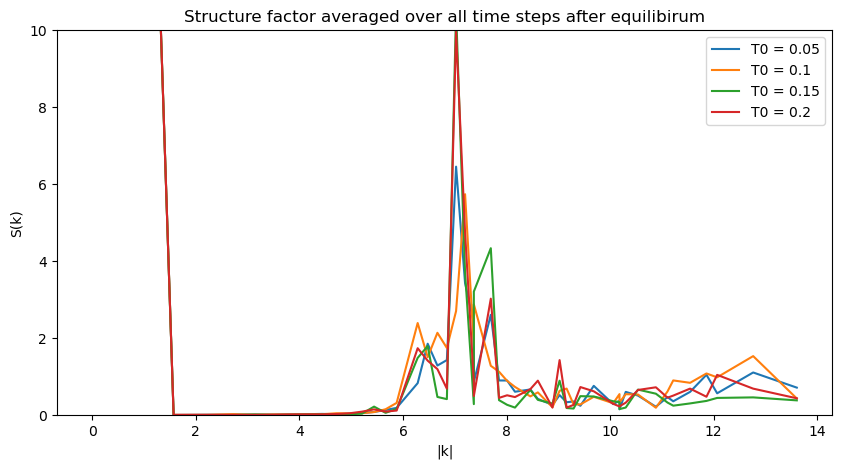

In [148]:
i = 0
for sk in sks:
    plt.plot(unique_kmags, np.mean(sk, axis=0), label="T0 = " + str(Ts[i]))
    i += 1

plt.ylim(0, 10)
plt.xlabel("|k|")
plt.ylabel("S(k)")
plt.title("Structure factor averaged over all time steps after equilibirum")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


The melting temperature is likely around $T = 0.15$